In [12]:
import numpy as np
import pandas as pd
from statsmodels.stats.power import TTestPower
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt

In [3]:
# 24 hr bW changes

# load data for BW
data = {
    "Group": ["veh", "veh", "veh", "veh", "veh", "veh", "veh", "veh", "veh", "veh", "veh",
              "cgrp", "cgrp", "cgrp", "cgrp", "cgrp", "cgrp", "cgrp", "cgrp", "cgrp", "cgrp", "cgrp"],
    "Value": [0.7, -2, -0.2, -5.6, -2.7, 0.2, 1.7, 10.9, 4.9, -2.2, 4.9,
              -3.2, -17.5, 6.5, -6.9, -26.4, 0.1, -6.3, 1.3, -1.1, -5.7, -11.3]
}
df = pd.DataFrame(data)

# Reshape data for paired t-test
veh_values = df[df["Group"] == "veh"]["Value"].values
cgrp_values = df[df["Group"] == "cgrp"]["Value"].values
diff_values = veh_values - cgrp_values

In [4]:
cohens_d = np.mean(diff_values)/np.std(diff_values, ddof=1)
cohens_d


0.8613435171305704

In [6]:
# Parameters for the power analysis
effect_size = cohens_d  # Cohen's d, can adjust based on expected effect size
alpha = 0.05  # Significance level
power = 0.8  # Desired power (1 - beta)

power_analysis = TTestPower()
# Calculate the required sample size
required_sample_size = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative = 'two-sided')
# Print the result
print(f"Required pairs: {np.ceil(required_sample_size)}")


Required pairs: 13.0


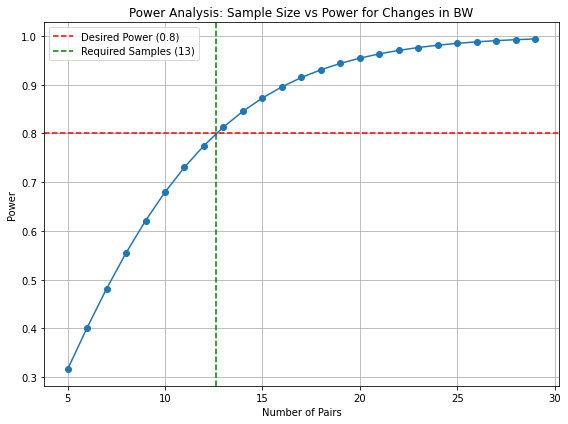

In [9]:
# Range of sample sizes for plotting
sample_sizes = np.arange(5, 30, 1)
powers = power_analysis.power(effect_size=cohens_d, nobs=sample_sizes, alpha=alpha, alternative='two-sided')

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, powers, marker='o')
plt.axhline(y=power, color='r', linestyle='--', label='Desired Power (0.8)')
plt.axvline(x=required_sample_size, color='g', linestyle='--', label=f'Required Samples ({int(np.ceil(required_sample_size))})')
plt.title('Power Analysis: Sample Size vs Power for Changes in BW')
plt.xlabel('Number of Pairs')
plt.ylabel('Power')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [13]:
# Perform paired t-test
t_stat, p_value = ttest_rel(veh_values, cgrp_values)
t_stat, p_value 
# confirming getting the same result as prism 

(2.8567532619271607, 0.017051535104439786)

In [14]:
#load dataset for cumulative intake 
data = {
    "Animal ID": [304, 307, 308, 312, 314, 315, 317, 319, 321, 322, 304, 307, 308, 312, 314, 315, 317, 319, 321, 322],
    "1hr": [0.55, 2.08, 0, 0, 2.7, 1.04, 8.16, 3.1, 2.01, 0, 0, 1.13, 0, 1.26, 0, 0, 0, 3.19, 0.17, 0],
    "3hr": [4.97, 5.86, 6.26, 8.48, 8.22, 9.72, 12.84, 11.71, 9.61, 6.01, 2.44, 8.03, 4.35, 3.36, 3.05, 0, 12.64, 8.55, 1.54, 4.7],
    "6hr": [10.6, 10.17, 12.88, 10.46, 12.3, 12.41, 17.42, 17.39, 14.72, 9.54, 8.88, 8.14, 10.45, 7.62, 10.4, 3.57, 12.64, 11.9, 10.25, 5.65],
    "24hr": [25.54, 22.94, 26.06, 27.64, 29.88, 31.69, 36.48, 30.91, 29.9, 29.26, 20.37, 23.6, 26.67, 22.09, 31.06, 11.27, 31.16, 30.75, 28.37, 18.44],
    "Treatment": ["veh", "veh", "veh", "veh", "veh", "veh", "veh", "veh", "veh", "veh", 
                  "cgrp", "cgrp", "cgrp", "cgrp", "cgrp", "cgrp", "cgrp", "cgrp", "cgrp", "cgrp"]
}

df = pd.DataFrame(data)

In [34]:
# Reshape the dataframe correctly for repeated measures ANOVA
# Separate out the treatments for clarity
df_reshaped = df.pivot(index="Animal ID", columns="Treatment", values=["1hr", "3hr", "6hr", "24hr"])

# Flatten the multi-level columns for easier access
df_reshaped.columns = ['_'.join(col).strip() for col in df_reshaped.columns.values]
df_reshaped.reset_index(inplace=True)

# Display the reshaped dataframe to ensure correctness
df_reshaped.head(2)


,Animal ID,1hr_cgrp,1hr_veh,3hr_cgrp,3hr_veh,6hr_cgrp,6hr_veh,24hr_cgrp,24hr_veh
0,304,0.00,0.55,2.44,4.97,8.88,10.60,20.37,25.54
1,307,1.13,2.08,8.03,5.86,8.14,10.17,23.60,22.94


In [35]:
# Overall mean
grand_mean = df_reshaped[
    [f"{time}_{group}" for time in ["1hr", "3hr", "6hr", "24hr"] for group in ["cgrp", "veh"]]
].stack().mean()

# Main Effect of Treatment (cgrp vs veh)
treatment_means = {
    "veh": df_reshaped[[f"{time}_veh" for time in ["1hr", "3hr", "6hr", "24hr"]]].stack().mean(),
    "cgrp": df_reshaped[[f"{time}_cgrp" for time in ["1hr", "3hr", "6hr", "24hr"]]].stack().mean(),
}
SS_treatment = sum(
    [
        df_reshaped.shape[0] * len(["1hr", "3hr", "6hr", "24hr"]) * ((treatment_means[group] - grand_mean) ** 2)
        for group in ["veh", "cgrp"]
    ]
)

# Main Effect of Time (1hr, 3hr, 6hr, 24hr)
time_means = {
    time: df_reshaped[[f"{time}_veh", f"{time}_cgrp"]].stack().mean() for time in ["1hr", "3hr", "6hr", "24hr"]
}
SS_time = sum(
    [
        df_reshaped.shape[0] * 2 * ((time_means[time] - grand_mean) ** 2) for time in ["1hr", "3hr", "6hr", "24hr"]
    ]
)

# Interaction Effect (Treatment × Time)
interaction_means = {
    (time, group): df_reshaped[f"{time}_{group}"].mean()
    for time in ["1hr", "3hr", "6hr", "24hr"]
    for group in ["veh", "cgrp"]
}
SS_interaction = sum(
    [
        df_reshaped.shape[0]
        * ((interaction_means[(time, group)] - treatment_means[group] - time_means[time] + grand_mean) ** 2)
        for time in ["1hr", "3hr", "6hr", "24hr"]
        for group in ["veh", "cgrp"]
    ]
)

# Residual/Error SS
SS_error = sum(
    [
        ((df_reshaped[f"{time}_{group}"] - interaction_means[(time, group)]) ** 2).sum()
        for time in ["1hr", "3hr", "6hr", "24hr"]
        for group in ["veh", "cgrp"]
    ]
)

# Partial eta squared and Cohen's f
eta_squared_treatment = SS_treatment / (SS_treatment + SS_error)
eta_squared_time = SS_time / (SS_time + SS_error)
eta_squared_interaction = SS_interaction / (SS_interaction + SS_error)

f_treatment = np.sqrt(eta_squared_treatment / (1 - eta_squared_treatment))
f_time = np.sqrt(eta_squared_time / (1 - eta_squared_time))
f_interaction = np.sqrt(eta_squared_interaction / (1 - eta_squared_interaction))

# Display results
{
    "Partial Eta Squared (Treatment)": eta_squared_treatment,
    "Partial Eta Squared (Time)": eta_squared_time,
    "Partial Eta Squared (Interaction)": eta_squared_interaction,
    "Cohen's f (Treatment)": f_treatment,
    "Cohen's f (Time)": f_time,
    "Cohen's f (Interaction)": f_interaction,
}


{'Partial Eta Squared (Treatment)': 0.1971758349963805,
 'Partial Eta Squared (Time)': 0.8876354493833795,
 'Partial Eta Squared (Interaction)': 0.030852050963634758,
 "Cohen's f (Treatment)": 0.49558325771477496,
 "Cohen's f (Time)": 2.8106234118574682,
 "Cohen's f (Interaction)": 0.17842141510083143}

In [62]:
from statsmodels.stats.power import FTestAnovaPower

# Parameters for two-way repeated measures ANOVA
effect_size = 0.5 # cohen's f for treatment 
#within_subject_correlation = 0.6  # Adjust for sphericity violations
#adjusted_effect_size = effect_size * np.sqrt(1 - within_subject_correlation)


# Number of measurements (time points) and groups (e.g., treatments)
num_measurements = 4  # e.g., 1hr, 3hr, 6hr, 24hr
num_groups = 2  # e.g., "veh", "cgrp"

# Adjust degrees of freedom (repeated measures design)
df_between = num_groups - 1
df_within = (num_measurements - 1) * (num_groups - 1)

# Range of sample sizes for exploration
sample_sizes = np.arange(5, 30, 1)  # Sample sizes from 5 to 50
power_analysis_f = FTestAnovaPower()

required_sample_size_f = power_analysis_f.solve_power(effect_size = effect_size, alpha = 0.05, power = 0.8)/num_measurements
print(required_sample_size_f)


8.357340716593033


In [63]:
adjusted_effect_size


0.31622776601683794

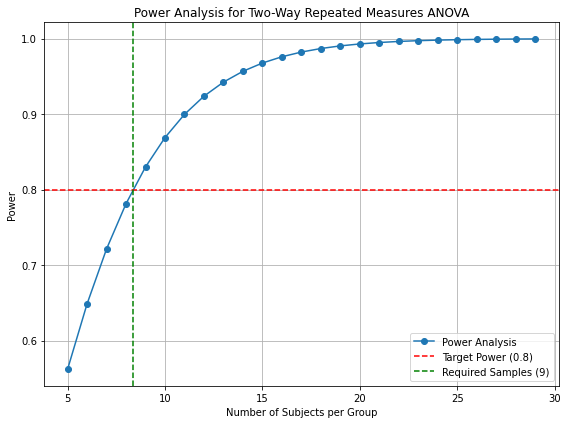

In [65]:
power_values_f = [
    power_analysis.solve_power(
        effect_size=effect_size,
        alpha=0.05,
        power=None,
        nobs=n * num_measurements,  # Total observations
    )
    for n in sample_sizes
]

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, power_values_f, label="Power Analysis", marker="o")
plt.axhline(0.8, color="red", linestyle="--", label="Target Power (0.8)")
plt.axvline(
    x=required_sample_size_f,
    color="green",
    linestyle="--",
    label=f"Required Samples ({int(np.ceil(required_sample_size_f))})",
)
plt.xlabel("Number of Subjects per Group")
plt.ylabel("Power")
plt.title("Power Analysis for Two-Way Repeated Measures ANOVA")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()